In [576]:
import numpy as np
import random
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [830]:
class WrightFisher():
    """
    Haploid Wright-Fisher model
    
    Parameters:
    N: population size
    """
    def __init__(self, N):
        self.N = N
        
    # Run Wright-Fisher simulation
    def simulate(self, allele_count, max_generations):
        # Create array of population alleles per generation
        population_alleles = np.full(max_generations + 1, None)
        # Set allele counts for initial generation
        population_alleles[0] = allele_count
        
        # Initialise counters
        gen = 0
        max_allele_counts = allele_count
        
        # Repeat for n generations
        while gen < max_generations:
            gen += 1
            # Simulate number of copies in next generation
            population_alleles[gen] = np.random.binomial(n = self.N,
                                                         p = population_alleles[gen - 1] / self.N)
        
        return population_alleles
    
    # Plot distribution of maximum allele count
    def plotMaxAllele(self, max_allele_counts):
        plt.figure(figsize = (10, 5))
        max_allele_hist = plt.hist(max_allele_counts,
                                   color = "orange",
                                   edgecolor = "black", 
                                   linewidth = 1.2,
                                   bins = min(max(max_allele_counts), 100))
        plt.xlabel("Max Allele Size") 
        plt.ylabel("Count") 
        plt.title("Distribution of Maximum Allele Number Reached")
        plt.show()
        
    # Plot distribution of time for simulations where the variant fixes or is lost
    def plotTime(self, fixation_times, loss_times, combine_plots = False):
        
        # Check whether to plot data on the same axis
        if combine_plots:
            plt.figure(figsize = (10, 5))
            # Plot fixation histogram
            plt.hist(fixation_times, color = "lime", label = "Fixed",
                     edgecolor = "black", linewidth = 1.2,
                     bins = 50, alpha = 0.5)
            # Also plot loss histogram on same axis
            plt.hist(loss_times, color = "red", label = "Lost",
                     edgecolor = "black", linewidth = 1.2,
                     bins = 50, alpha = 0.5)
            plt.xlabel("Time") 
            plt.ylabel("Count")
            plt.title("Distribution of Time Taken for the Allele to Fix or be Lost")
            plt.legend(loc = "upper right")
            
        # Otherwise create subplots
        else:
            fig, axes = plt.subplots(1, 2, figsize = (12, 5))
            axes[0].hist(fixation_times, color = "lime", label = "Fixed",
                         edgecolor = "black", linewidth = 1.2,
                         bins = 50, alpha = 0.5)
            axes[1].hist(loss_times, color = "red", label = "Lost",
                         edgecolor = "black", linewidth = 1.2,
                         bins = 50, alpha = 0.5)
            axes[0].title.set_text("Fixation")
            axes[1].title.set_text("Loss")
            fig.suptitle("Distribution of Time Taken for the Allele to Fix or be Lost\n",
                         y = 1.05)
            
            for ax in axes:
                ax.set_xlabel("Time")
                ax.set_ylabel("Count")
            
        plt.show()
    
    # Plot density heatmap of allele counts over time
    def plotPathDensity(self, path_density, title = "Path Density", 
                        fontsize = 12, cmap = "viridis",
                        logscale = True):
        # Plot density heatmap of allele counts over time
        if logscale:
            density_map = sns.heatmap(np.log(path_density + 1), cmap = cmap)
        else:
            density_map = sns.heatmap(path_density, cmap = cmap)
        density_map.set_xlabel("Time", fontsize = fontsize)
        density_map.set_ylabel("Allele Count", fontsize = fontsize)
        density_map.set_title(title, fontsize = fontsize + 2)
        density_map.figure.set_size_inches(13, 10)
        if logscale:
            density_map.collections[0].colorbar.set_label("Log(Density + 1)",
                                                          fontsize = fontsize)
        else:
            density_map.collections[0].colorbar.set_label("Density",
                                                          fontsize = fontsize)
        density_map.set(xlim = (1, path_density.shape[1]))
        
    # Plot distribution of number of copies of an allele over all generations
    def plotAlleleCount(self, all_allele_counts, logscale = True):
        plt.figure(figsize = (10, 5))
        allele_counts_bar = plt.bar(range(len(all_allele_counts)),
                                    all_allele_counts,
                                    color = "skyblue",
                                    edgecolor = "black", 
                                    linewidth = 1.2)
        plt.xlabel("Total Allele Copies") 
        plt.ylabel("Count")
        plt.title("Distribution of Total Allele Copies Across Generations")
        plt.yscale("log" if logscale else "linear")
        plt.show()
    
    def repeatSimulate(self, allele_count, max_generations = 500, n_times = 1000):
        # The highest numbers the allele reaches per simulation
        max_allele_counts = np.zeros(n_times, dtype = int)
        # The times taken for the allele to fix or be lost
        end_times = np.zeros(n_times, dtype = int)
        # Density of allele counts over time for n simulations
        path_density = np.zeros((self.N + 1, max_generations), dtype = int)
        
        # Total time for simulations that fix and loose the allele
        fixation_times = np.array([])
        loss_times = np.array([])
        # Average time for simulations that fix and loose the allele
        mean_fixation_time = None
        mean_loss_time = None
        
        # Run the simulation n times
        for i in range(n_times):
            # Run Wright-Fisher model
            population_alleles = self.simulate(allele_count, max_generations)
            # Get the maximum allele count and simulation end time
            max_allele_counts[i] = max(population_alleles)
            end_times[i] = len(population_alleles[population_alleles != 0])
            
            # Increment path density for the new allele counts over time
            for j in range(1, len(population_alleles)):
                path_density[population_alleles[j]][j - 1] += 1
                
            # Check if allele fixes
            if population_alleles[-1] == self.N:
                # Add time when allele fixes
                fixation_times = np.append(fixation_times,
                                               np.where(population_alleles == self.N)[0][0])
            else:
                # Add time taken for allele to be lost
                loss_times = np.append(loss_times, end_times[i])
                
        # Number of simulations in which the allele fixes and is lost
        n_fixed = len(fixation_times)
        n_lost = len(loss_times)
        
        # Calculate average fixation and loss time
        if n_fixed > 0:
            mean_fixation_time = sum(fixation_times) / len(fixation_times)
        if n_lost > 0:
            mean_loss_time = sum(loss_times) / len(loss_times)
            
        # Number of copies of the allele over all generations
        all_allele_counts = np.array([sum(row) for row in path_density])
        
        return {"max_allele_counts": max_allele_counts,
                "end_times": end_times,
                "path_density": path_density,
                "n_fixed": n_fixed,
                "mean_fixation_time": mean_fixation_time,
                "mean_loss_time": mean_loss_time,
                "fixation_times": fixation_times,
                "loss_times": loss_times,
                "all_allele_counts": all_allele_counts}

Fixed 7 times
Average fixation time of 168.571
Average loss time of 10.348


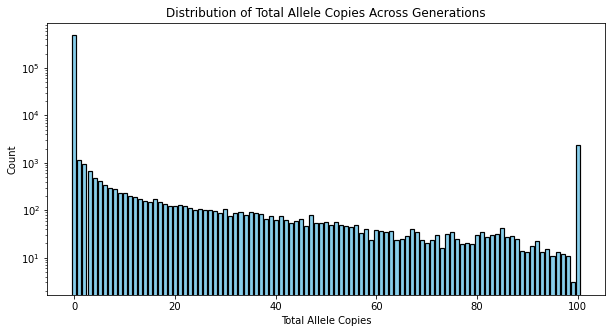

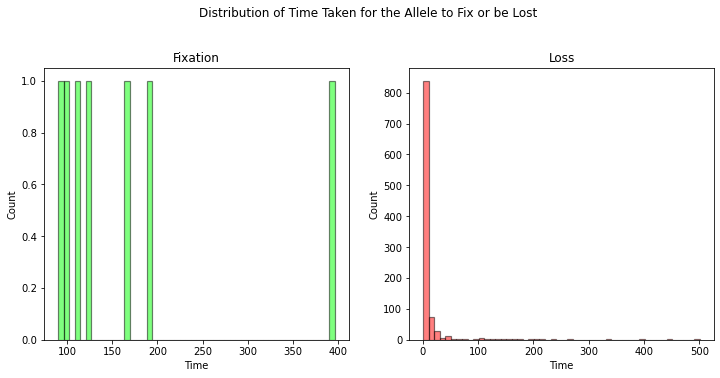

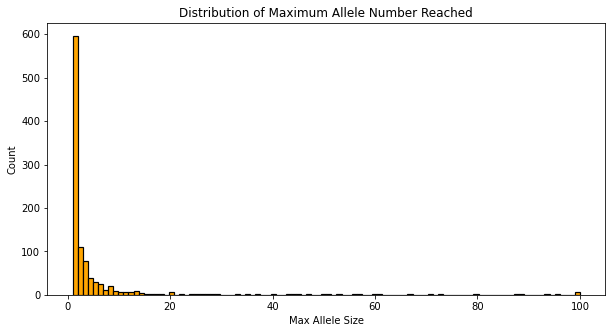

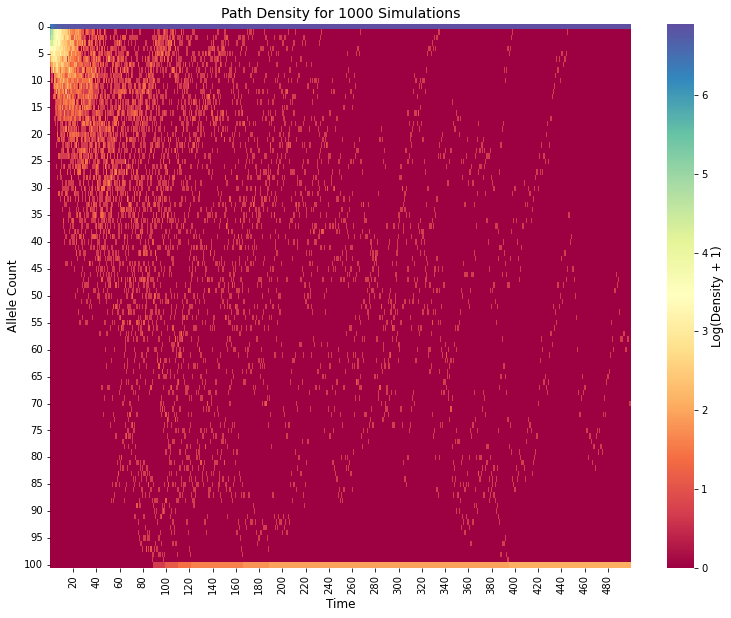

In [831]:
wf_simulator = WrightFisher(N = 100)
simulation_results = wf_simulator.repeatSimulate(allele_count = 1, n_times = 1000)

print("Fixed " + str(simulation_results["n_fixed"]) + " times")
print("Average fixation time of " + str(round(simulation_results["mean_fixation_time"], 3)))
print("Average loss time of " + str(round(simulation_results["mean_loss_time"], 3)))

wf_simulator.plotAlleleCount(simulation_results["all_allele_counts"], logscale = True)
wf_simulator.plotTime(simulation_results["fixation_times"], simulation_results["loss_times"])
wf_simulator.plotMaxAllele(simulation_results["max_allele_counts"])
wf_simulator.plotPathDensity(simulation_results["path_density"], 
                             cmap = "Spectral", logscale = True,
                             title = "Path Density for 1000 Simulations")